In [1]:
from keras.preprocessing.text import Tokenizer
import numpy as np
import pandas as pd
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, to_categorical
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
import pickle
import re
import operator

import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.
/Users/aaronfrederick/Desktop/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


In [2]:
corpus = pickle.load(open('corpus.pkl', 'rb'))
cleaned = [re.sub('[^a-zA-Z ]', '', song) for song in corpus]

/Users/aaronfrederick/Desktop/venv/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


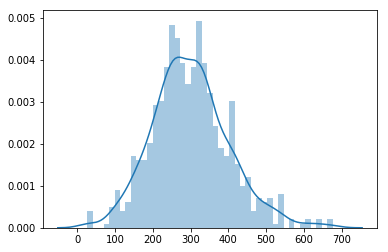

In [3]:
cleaned = list(set(cleaned))
tokens = [song.split() for song in cleaned]

#Turn words to ints
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokens)
sequences = tokenizer.texts_to_sequences(tokens)
vocab_size = len(tokenizer.word_index) + 1

sequences = np.array(sequences)

lengths = [len(song) for song in sequences]
#plot distribution of sequence lengths
sns.distplot(lengths, bins = 45)

In [4]:
#grab data in a length that makes sense, padding the almost-long enoughs and truncating the too-longs
pad_matrix = np.zeros((688,330))

for i in range(688):
    if len(sequences[i]) > 280:
        for j, value in enumerate(sequences[i]):
            if j <330:
                pad_matrix[i][j] = value

In [5]:
#grab nonzero elements of the padded matrix
new_pad = np.array([non_zero for non_zero in pad_matrix if non_zero.sum() > 0])

z_count = 0
for row in new_pad:
    for val in row:
        if val == 0:
            z_count += 1

#print percent of nonzero values in the dataset 
(new_pad.shape[0] * new_pad.shape[1] - z_count) / (new_pad.shape[0] * new_pad.shape[1])

0.9764724997968965

In [6]:
X, y = new_pad[:,:-1], new_pad[:,-1]
y = to_categorical(y, num_classes=vocab_size)
seq_length = X.shape[1]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)

In [7]:
#Create model *DONT USE DROPOUT - DEPENDENCY ERROR*
model = Sequential()
model.add(Embedding(vocab_size, output_dim=50, input_length=seq_length))
model.add(LSTM(24, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.05)))
model.add(LSTM(14, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.05)))
model.add(Dense(vocab_size, activation='sigmoid'))

In [8]:
sgd = optimizers.SGD(lr=0.05, decay=0, momentum=0.1, nesterov=True)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 329, 50)           270250    
_________________________________________________________________
lstm_1 (LSTM)                (None, 329, 24)           7200      
_________________________________________________________________
lstm_2 (LSTM)                (None, 14)                2184      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 5405)              27025     
Total params: 306,719
Trainable params: 306,719
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.fit(X_train, y_train, validation_data=[X_valid, y_valid], batch_size=128, epochs=5)

Train on 335 samples, validate on 38 samples
Epoch 1/5
335/335 [==============================] - 4s 13ms/step - loss: 13.7877 - acc: 0.2239 - val_loss: 13.6609 - val_acc: 0.3684
Epoch 2/5
335/335 [==============================] - 2s 7ms/step - loss: 13.6118 - acc: 0.3552 - val_loss: 13.4887 - val_acc: 0.3684
Epoch 3/5
335/335 [==============================] - 2s 7ms/step - loss: 13.4413 - acc: 0.3552 - val_loss: 13.3222 - val_acc: 0.3684
Epoch 4/5
335/335 [==============================] - 2s 7ms/step - loss: 13.2766 - acc: 0.3552 - val_loss: 13.1613 - val_acc: 0.3684
Epoch 5/5
335/335 [==============================] - 2s 7ms/step - loss: 13.1172 - acc: 0.3552 - val_loss: 13.0056 - val_acc: 0.3684


In [11]:
def gen_sequence(seed, model=model, tokenizer=tokenizer, length=329, n_words=70):
    result = []
    in_word = seed
    for _ in range(n_words):
        encoded = tokenizer.texts_to_sequences([in_word])[0]
        encoded = pad_sequences([encoded], maxlen=length, truncating='pre')
        pred = model.predict_classes(encoded)
        out = ''
        for word, index in tokenizer.word_index.items():
            if index==pred:
                out = word
                break
        in_word += ' ' + out
        result.append(out)
    return ' '.join(result)

In [12]:
gen_sequence('me', n_words=5)

'    '

In [13]:
for seed in ['me', 'you', 'why', 'i', 'hate', 'seed', 'love', 'what']:
    encoded = tokenizer.texts_to_sequences([seed])[0]
    encoded = pad_sequences([encoded], maxlen=329, truncating='pre')
    pred = model.predict_classes(encoded)

    print(pred)

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
